In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, acf, pacf
from arch import arch_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

In [2]:
# 1. Cargar datos
df = pd.read_csv(r'C:\Users\MIGUEL HERRERA\Downloads\seoul_air_1988_2021.csv')

In [65]:
data = df[['dt', 'loc', 'no2']]
data = data[data['loc'] == 124].drop(columns=['loc'])

# Eliminar valores atípicos extremos
df_no2 = data['no2']
q1, q3 = df_no2.quantile([0.01, 0.99])
data = data[(df_no2 >= q1) & (df_no2 <= q3)]

# Imputación de valores faltantes
data['no2'] = data['no2'].interpolate(method='cubic')

# Transformación de la serie temporal
data['dt'] = pd.to_datetime(data['dt'].astype(str), format='%Y%m%d%H')
data.set_index('dt', inplace=True)
hourly = data['no2'].asfreq('H').dropna()

# División en train, validation y test
train_size = int(len(hourly) * 0.7)
val_size = int(len(hourly) * 0.15)
test_size = len(hourly) - train_size - val_size

train = hourly.iloc[:train_size]
validation = hourly.iloc[train_size:train_size + val_size]
test = hourly.iloc[train_size + val_size:]
forecast_steps = len(validation) + len(test)

# Filtrar datos para graficar
filtered_series = hourly["2005":"2020"]
filtered_train = train.loc[filtered_series.index.intersection(train.index)]
filtered_validation = validation.loc[filtered_series.index.intersection(validation.index)]
filtered_test = test.loc[filtered_series.index.intersection(test.index)]

In [66]:
train_to_plot = train[-int(len(train) * 0.2):]

In [67]:
# Diccionario para almacenar predicciones
models_predictions = {}

# Modelo GARCH
garch_model = arch_model(train, vol='Garch', p=1, q=1, rescale=False).fit(disp="off")
garch_forecast = garch_model.forecast(horizon=len(test))
models_predictions['GARCH'] = garch_forecast.mean.iloc[-1].values if not garch_forecast.mean.empty else np.zeros(len(test))

C:\Users\MIGUEL HERRERA\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


In [68]:
# Escalado para Redes Neuronales
scaler = MinMaxScaler()
filtered_series_scaled = scaler.fit_transform(hourly.values.reshape(-1, 1))

X = np.array([filtered_series_scaled[i-168:i].flatten() for i in range(168, len(filtered_series_scaled))])
y = np.array([filtered_series_scaled[i] for i in range(168, len(filtered_series_scaled))])

In [73]:
import numpy as np

print("¿Hay NaNs en X?", np.isnan(X).sum())
print("¿Hay NaNs en y?", np.isnan(y).sum())
print("¿Hay valores infinitos en X?", np.isinf(X).sum())
print("¿Hay valores infinitos en y?", np.isinf(y).sum())
print("Máximo valor en X:", X.max())
print("Mínimo valor en X:", X.min())

¿Hay NaNs en X? 0
¿Hay NaNs en y? 0
¿Hay valores infinitos en X? 0
¿Hay valores infinitos en y? 0
Máximo valor en X: 1.0
Mínimo valor en X: 0.0


In [69]:
# Modelo MLP
model_mlp = MLPRegressor(hidden_layer_sizes=(100,), max_iter=1000, learning_rate_init=0.01, solver='adam')
model_mlp.fit(X, y.ravel())
pred_mlp = scaler.inverse_transform(model_mlp.predict(X[-forecast_steps:].reshape(forecast_steps, -1)).reshape(-1, 1)).flatten()
models_predictions['MLP'] = pred_mlp

In [70]:
# Modelo RNN
X_rnn = X.reshape(X.shape[0], X.shape[1], 1)
model_rnn = Sequential([
    SimpleRNN(50, activation='relu', return_sequences=True, input_shape=(24, 1)),
    SimpleRNN(25, activation='relu'),
    Dense(1)
])
model_rnn.compile(optimizer='adam', loss='mse')
model_rnn.fit(X_rnn, y, epochs=5, batch_size=128, verbose=1)  
pred_rnn = scaler.inverse_transform(model_rnn.predict(X_rnn[-forecast_steps:].reshape(forecast_steps, 168, 1))).flatten()
models_predictions['RNN'] = pred_rnn

C:\Users\MIGUEL HERRERA\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
2163/2163 ━━━━━━━━━━━━━━━━━━━━ 107s 48ms/step - loss: 0.0131
Epoch 2/5
2163/2163 ━━━━━━━━━━━━━━━━━━━━ 103s 48ms/step - loss: 0.0065
Epoch 4/5
2163/2163 ━━━━━━━━━━━━━━━━━━━━ 103s 48ms/step - loss: 0.0064
2597/2597 ━━━━━━━━━━━━━━━━━━━━ 28s 11ms/step


In [74]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Asegurar que X tenga la forma correcta
X = np.array([filtered_series_scaled[i-168:i] for i in range(168, len(filtered_series_scaled))])
X = X.reshape(X.shape[0], 168, 1)  
y = np.array([filtered_series_scaled[i] for i in range(168, len(filtered_series_scaled))])

# Construcción del modelo LSTM con activación tanh y dropout
model_lstm = Sequential([
    LSTM(50, activation='tanh', return_sequences=True, input_shape=(168, 1)),
    Dropout(0.2),
    LSTM(25, activation='tanh'),
    Dense(1)
])

# Compilar modelo con Adam y learning_rate reducido
model_lstm.compile(optimizer=Adam(learning_rate=0.0001, clipnorm=1.0), loss='mse')

# Entrenamiento del modelo
model_lstm.fit(X, y, epochs=5, batch_size=128, verbose=1)

C:\Users\MIGUEL HERRERA\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
2163/2163 ━━━━━━━━━━━━━━━━━━━━ 294s 134ms/step - loss: 0.0307
Epoch 2/5
2163/2163 ━━━━━━━━━━━━━━━━━━━━ 297s 137ms/step - loss: 0.0108
Epoch 3/5
2163/2163 ━━━━━━━━━━━━━━━━━━━━ 348s 149ms/step - loss: 0.0075
Epoch 4/5
2163/2163 ━━━━━━━━━━━━━━━━━━━━ 319s 148ms/step - loss: 0.0072
Epoch 5/5
2163/2163 ━━━━━━━━━━━━━━━━━━━━ 327s 151ms/step - loss: 0.0071


In [79]:
# Generar predicciones con el modelo LSTM
pred_lstm = model_lstm.predict(X[-forecast_steps:].reshape(forecast_steps, 168, 1))

# Asegurar que la salida es unidimensional
pred_lstm = pred_lstm.flatten()  # o pred_lstm.ravel()

# Invertir la transformación de escala
pred_lstm = scaler.inverse_transform(pred_lstm.reshape(-1, 1)).flatten()

# Guardar en models_predictions
models_predictions['LSTM'] = pred_lstm


2597/2597 ━━━━━━━━━━━━━━━━━━━━ 69s 27ms/step


C:\Users\MIGUEL HERRERA\AppData\Local\Temp\ipykernel_17988\1178535098.py:55: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, new_row], ignore_index=True)


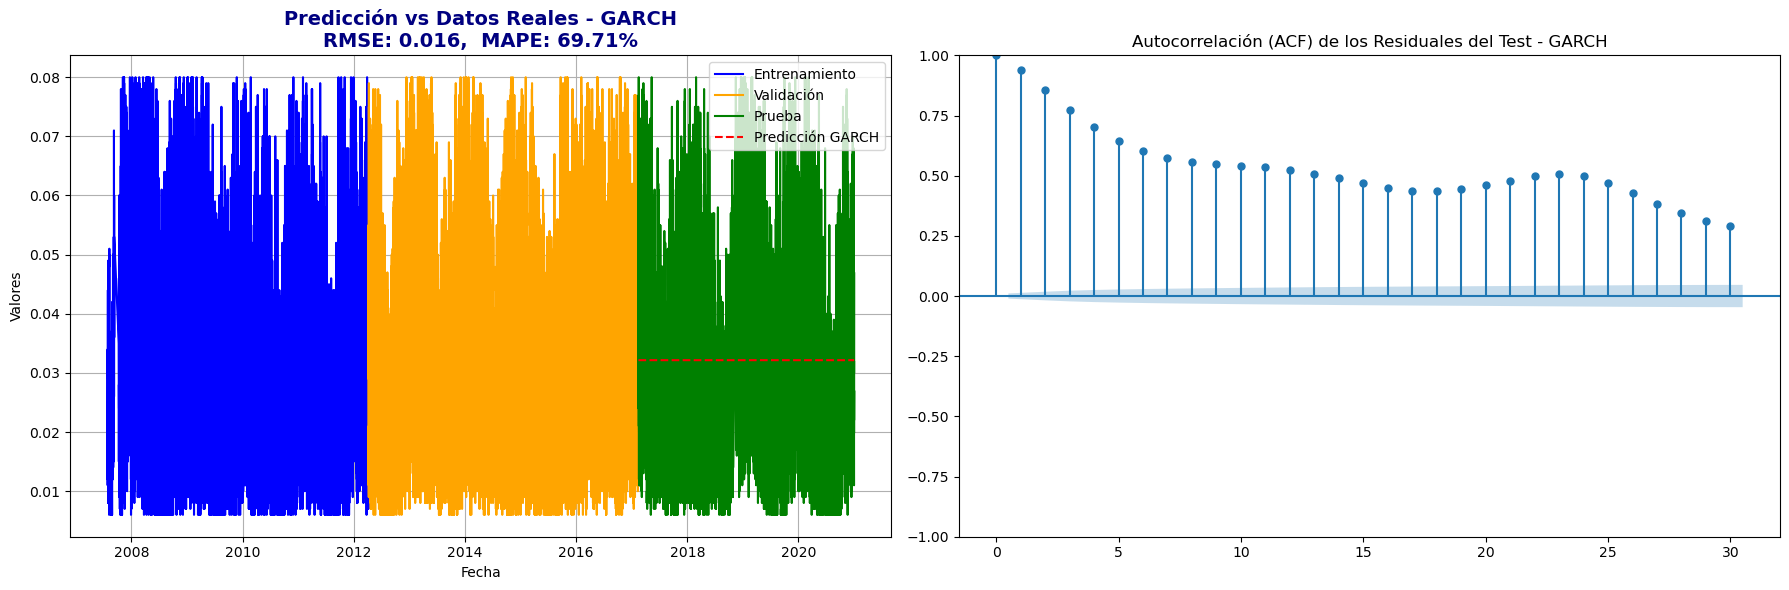

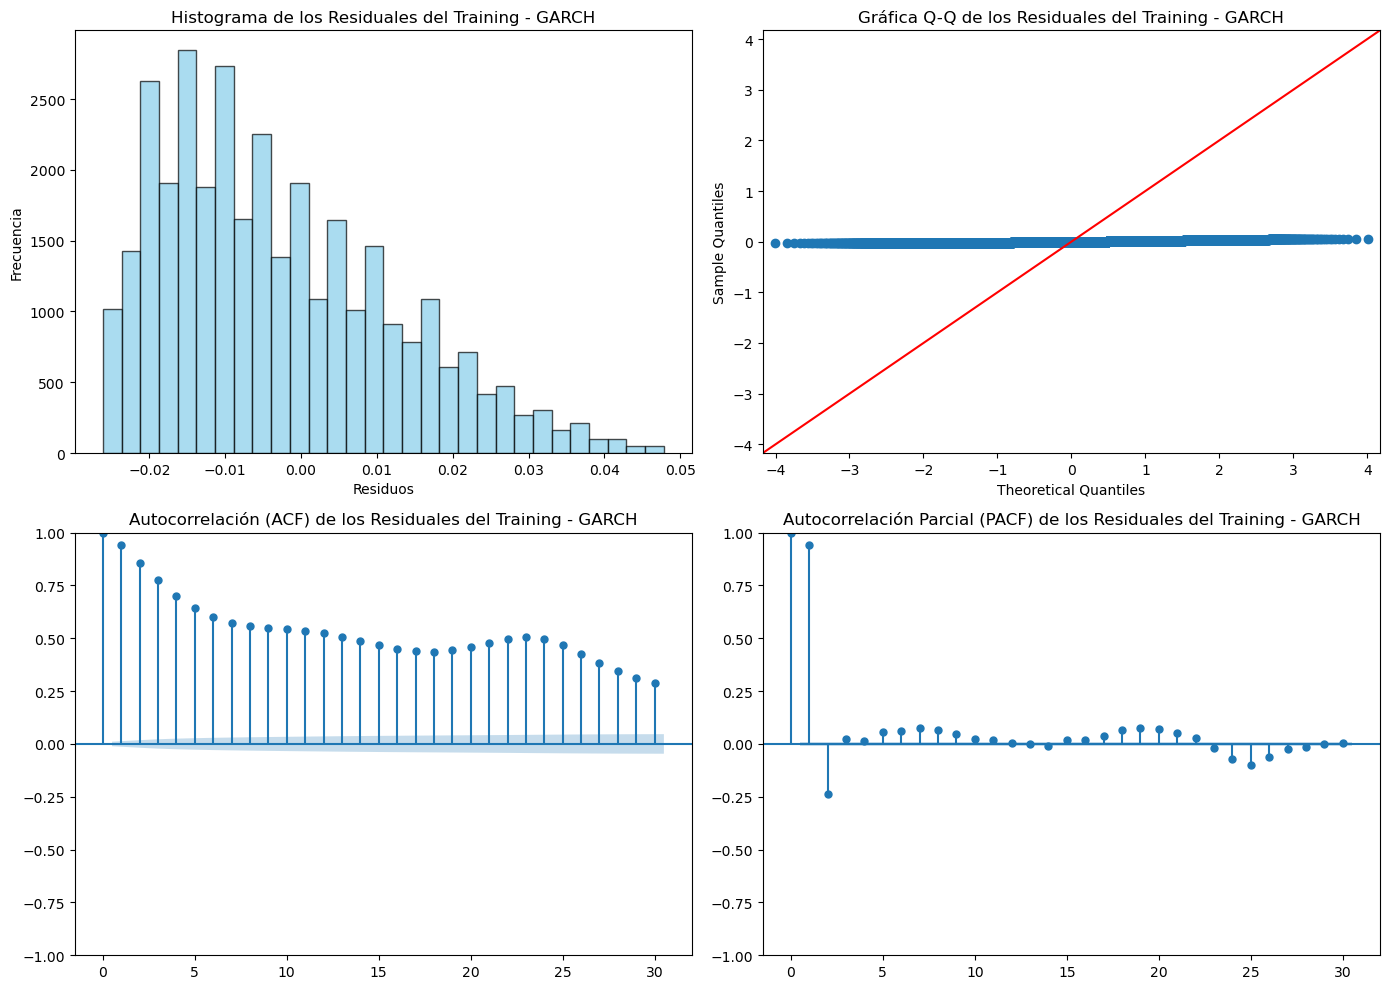

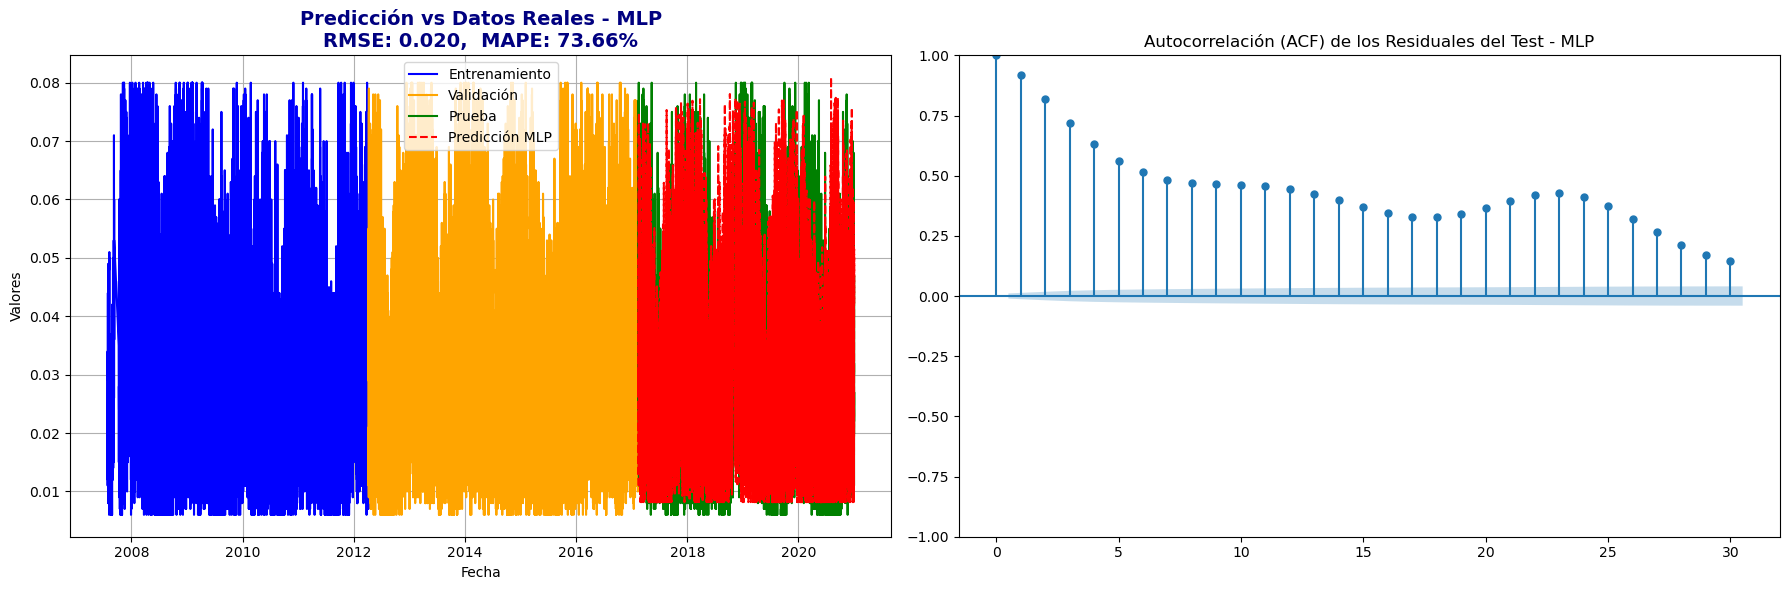

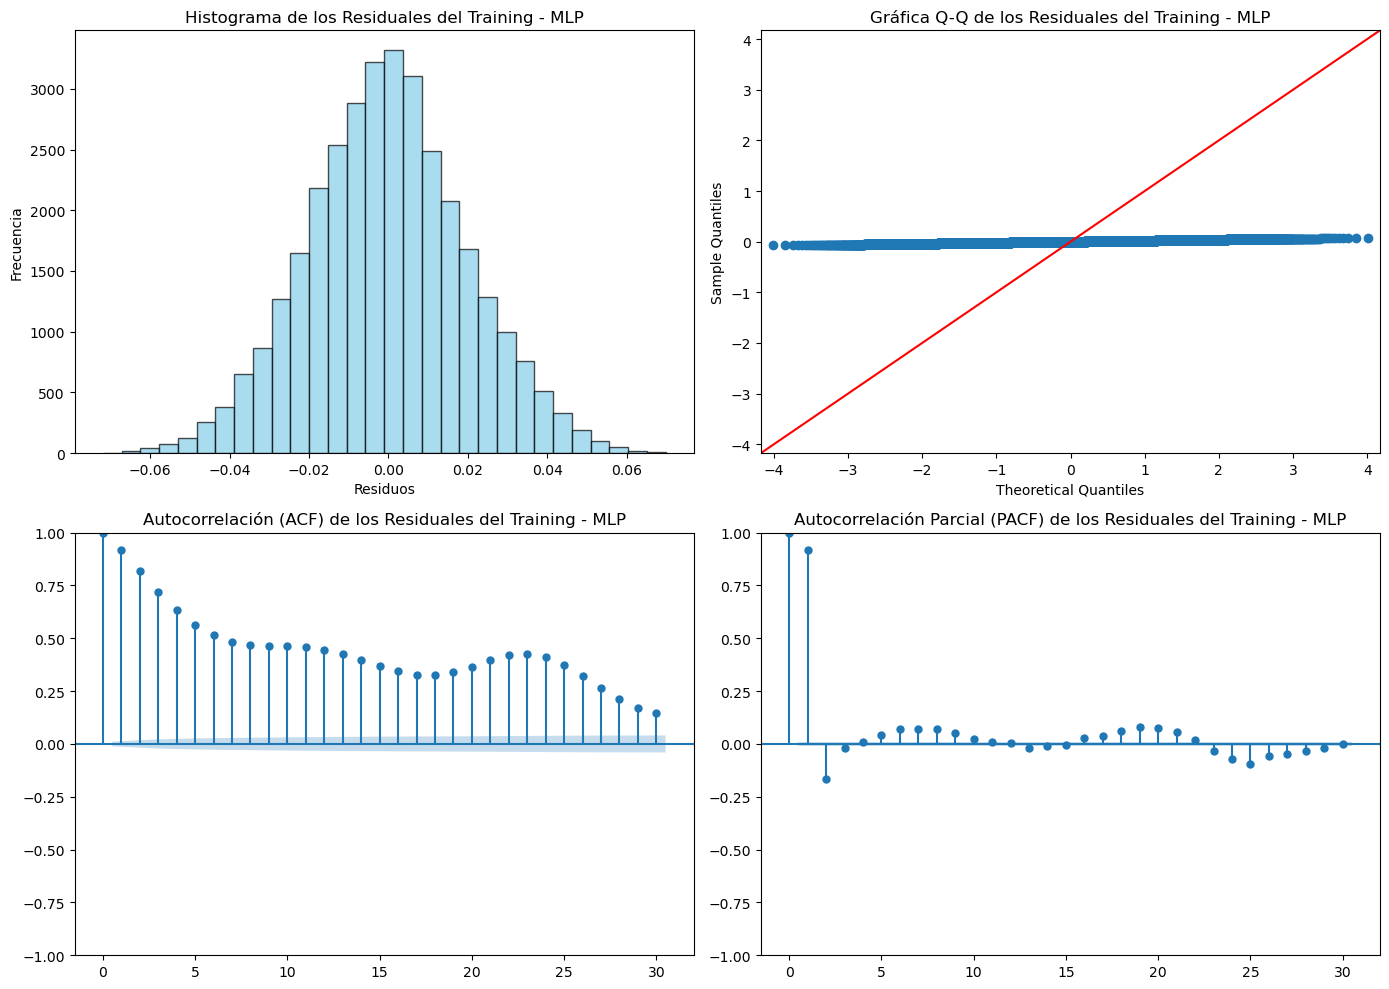

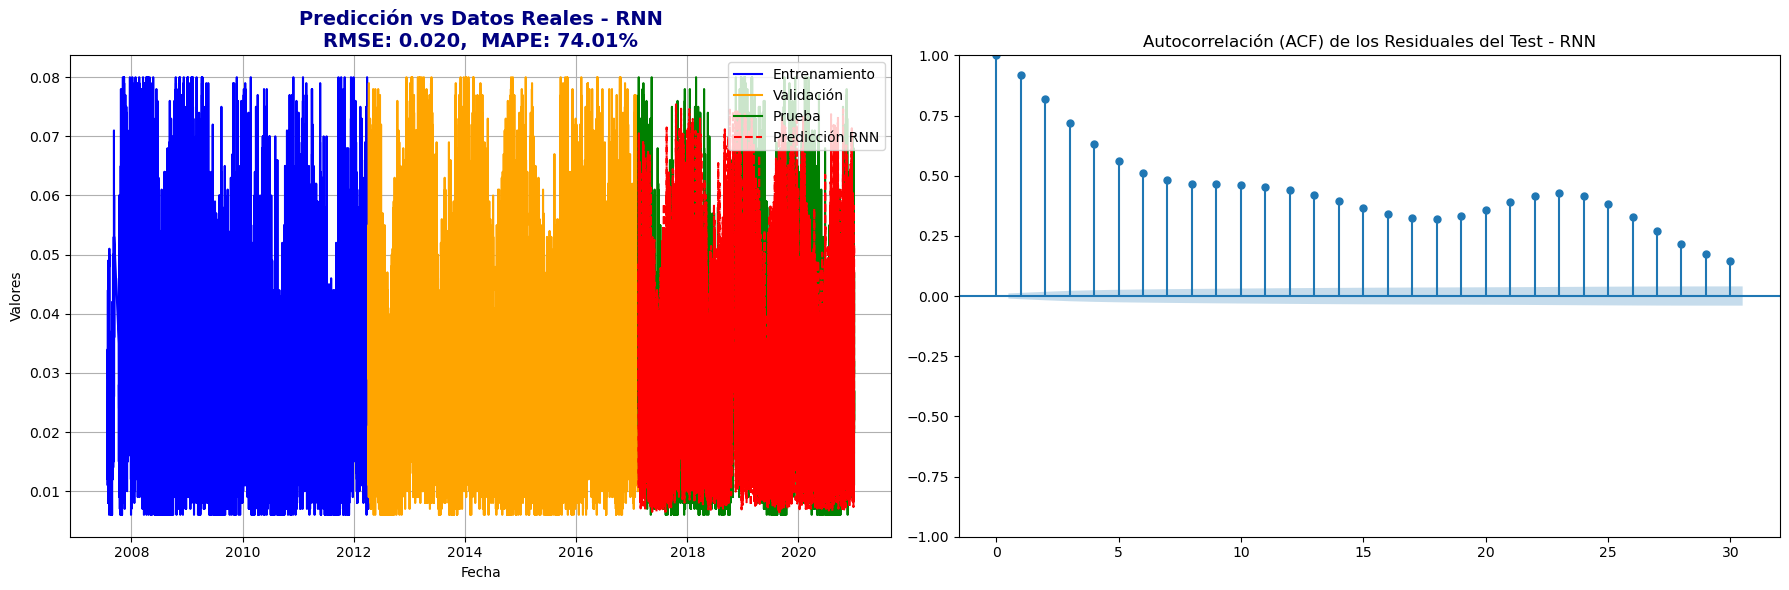

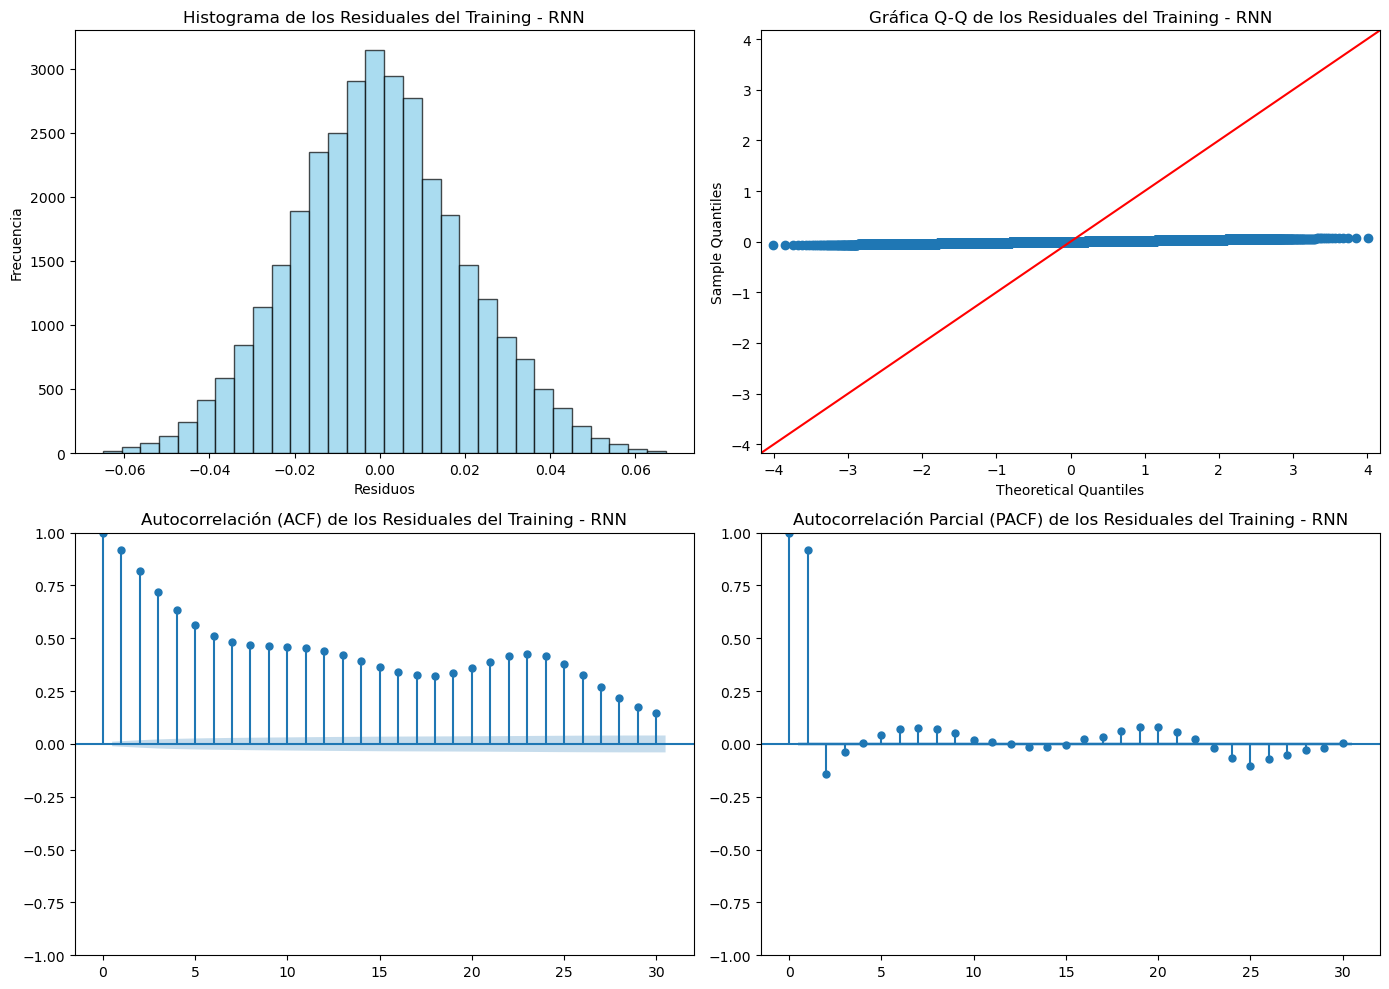

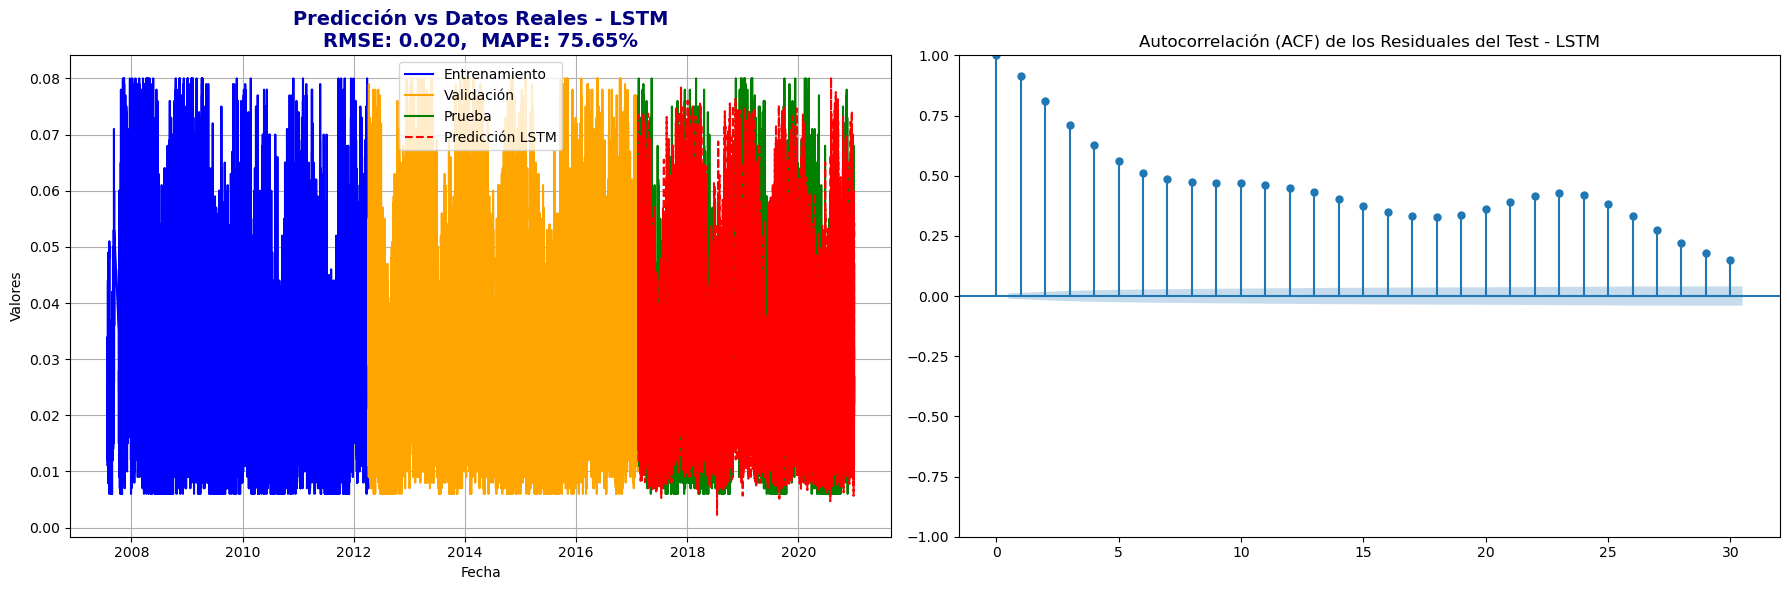

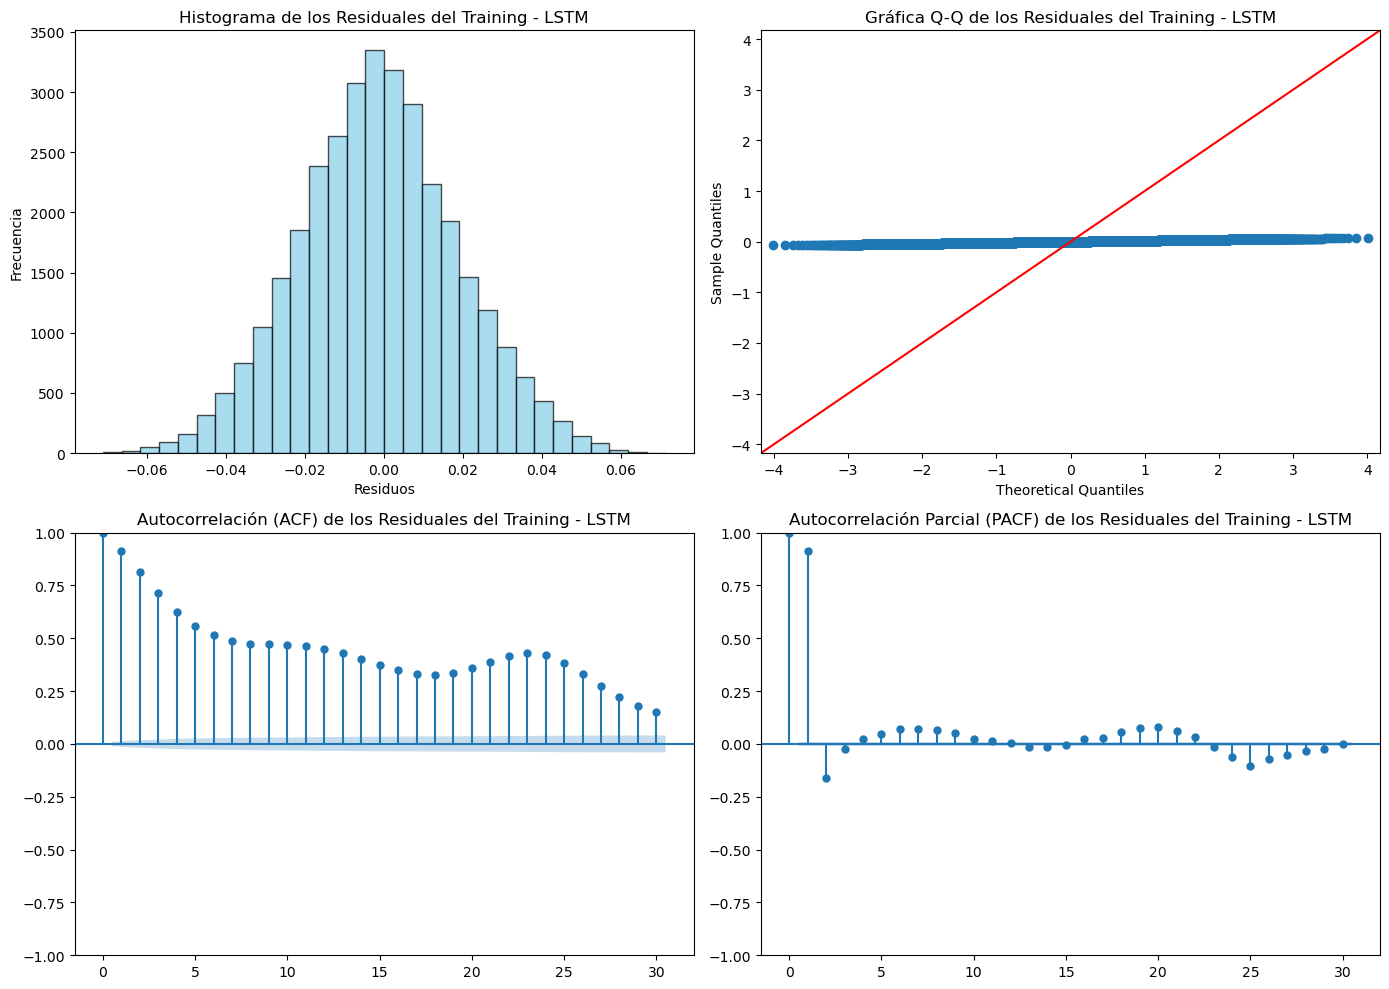

In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.api import SimpleExpSmoothing, ExponentialSmoothing, ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import shapiro
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# Crear DataFrame para almacenar resultados
results = pd.DataFrame(columns=['Modelo', 'RMSE', 'MAE', 'MAPE', 'R²', 'Ljung-Box (p-valor)', 
                                'Dickey-Fuller (p-valor)', 'Shapiro-Wilk (p-valor)'])

for model_name, prediction in models_predictions.items():
    prediction_series = pd.Series(prediction[:len(filtered_test)], index=filtered_test.index)

    # Manejo de NaNs en predicciones y datos reales
    prediction_series.fillna(filtered_train.mean(), inplace=True)
    filtered_test.dropna(inplace=True)

    if prediction_series.isna().any() or filtered_test.isna().any():
        print(f"Advertencia: Se encontraron NaNs en el modelo {model_name}, se omitirán para métricas.")
        continue  # Salta el modelo si hay NaNs persistentes

    # Cálculo de métricas
    rmse = np.sqrt(mean_squared_error(filtered_test, prediction_series))
    mae = mean_absolute_error(filtered_test, prediction_series)
    mape = mean_absolute_percentage_error(filtered_test, prediction_series) * 100
    r2 = 1 - (np.sum((filtered_test - prediction_series)**2) / np.sum((filtered_test - filtered_test.mean())**2))

    # Análisis de residuos
    model_residuals = (filtered_test - prediction_series).dropna()

    # Prueba de Ljung-Box
    ljung_p = acorr_ljungbox(model_residuals, lags=[10], return_df=True)['lb_pvalue'].values[0]

    # Prueba de Dickey-Fuller para estacionariedad
    adf_p = adfuller(model_residuals)[1]

    # Prueba de normalidad de Shapiro-Wilk
    if len(model_residuals) > 5000:  # Shapiro-Wilk es inestable con demasiados datos
        sample_residuals = model_residuals.sample(5000, random_state=42)
    else:
        sample_residuals = model_residuals

    shapiro_p = shapiro(sample_residuals)[1]

    # Agregar resultados al DataFrame usando pd.concat()
    new_row = pd.DataFrame({'Modelo': [model_name], 'RMSE': [rmse], 'MAE': [mae], 'MAPE': [mape], 'R²': [r2],
                            'Ljung-Box (p-valor)': [ljung_p], 'Dickey-Fuller (p-valor)': [adf_p],
                            'Shapiro-Wilk (p-valor)': [shapiro_p]})

    results = pd.concat([results, new_row], ignore_index=True)

    # FIGURA 1: Predicción vs Datos Reales + ACF de los residuales del test
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    
    # Gráfico de predicción vs datos reales
    axes[0].plot(train_to_plot.index, train_to_plot.values, label="Entrenamiento", color="blue")
    axes[0].plot(filtered_validation.index, filtered_validation.values, label="Validación", color="orange")
    axes[0].plot(filtered_test.index, filtered_test.values, label="Prueba", color="green")
    axes[0].plot(prediction_series.index, prediction_series.values, '--', label=f"Predicción {model_name}", color="red")
    
    axes[0].set_title(f"Predicción vs Datos Reales - {model_name}\nRMSE: {rmse:.3f},  MAPE: {mape:.2f}%", fontsize=14, fontweight='bold', color='navy')
    axes[0].set_xlabel("Fecha")
    axes[0].set_ylabel("Valores")
    axes[0].legend()
    axes[0].grid(True)
    
    # ACF de los residuales del test con banda de significancia
    plot_acf(model_residuals.dropna(), lags=30, alpha=0.05, ax=axes[1])
    axes[1].set_title(f"Autocorrelación (ACF) de los Residuales del Test - {model_name}")
    
    plt.tight_layout()
    plt.show()
    
    # FIGURA 2: Histograma de residuos + QQ Plot + ACF + PACF del entrenamiento
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Histograma de los residuos del entrenamiento
    axes[0, 0].hist(model_residuals.dropna(), bins=30, edgecolor='black', alpha=0.7, color='skyblue')
    axes[0, 0].set_title(f"Histograma de los Residuales del Training - {model_name}")
    axes[0, 0].set_xlabel("Residuos")
    axes[0, 0].set_ylabel("Frecuencia")
    
    # QQ-Plot de los residuos
    sm.qqplot(model_residuals.dropna(), line='45', ax=axes[0, 1])
    axes[0, 1].set_title(f"Gráfica Q-Q de los Residuales del Training - {model_name}")
    
    # ACF de los residuos del entrenamiento con banda de significancia
    plot_acf(model_residuals.dropna(), lags=30, alpha=0.05, ax=axes[1, 0])
    axes[1, 0].set_title(f"Autocorrelación (ACF) de los Residuales del Training - {model_name}")
    
    # PACF de los residuos del entrenamiento
    plot_pacf(model_residuals.dropna(), lags=30, alpha=0.05, ax=axes[1, 1])
    axes[1, 1].set_title(f"Autocorrelación Parcial (PACF) de los Residuales del Training - {model_name}")
    
    plt.tight_layout()
    plt.show()


In [86]:
results

,Modelo,RMSE,MAE,MAPE,R²,Ljung-Box (p-valor),Dickey-Fuller (p-valor),Shapiro-Wilk (p-valor)
0,GARCH,0.015527,0.013139,69.714014,-0.040051,0.0,1.242960e-28,1.682388e-38
1,MLP,0.020061,0.015872,73.655162,-0.736264,0.0,2.133144e-30,6.024701e-02
2,RNN,0.020091,0.015916,74.009551,-0.741426,0.0,2.037218e-30,2.994593e-02
3,LSTM,0.020178,0.015999,75.646867,-0.756500,0.0,2.075702e-30,5.264900e-02


In [ ]:
#  Modelos ES, ESHW, ARIMA
models = {
    'ES(1)': SimpleExpSmoothing(train).fit(smoothing_level=0.2, optimized=False),
    'ES(2)': SimpleExpSmoothing(train).fit(),
    'ES-HW(1)': ExponentialSmoothing(train, trend=None, seasonal=None).fit(),
    'ES-HW(2)': ExponentialSmoothing(train, trend='add', seasonal=None).fit(),
    'ES-HW(3)': ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=24).fit(),
    'ARIMA': ARIMA(train, order=(1, 1, 1)).fit()
}

models_predictions = {name: model.forecast(steps=forecast_steps) for name, model in models.items()}

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller
from scipy.stats import shapiro
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

# Crear DataFrame para almacenar resultados
results = pd.DataFrame(columns=['Modelo', 'RMSE', 'MAE', 'MAPE', 'R²', 'Ljung-Box (p-valor)', 
                                'Dickey-Fuller (p-valor)', 'Shapiro-Wilk (p-valor)'])

for model_name, prediction in models_predictions.items():
    prediction_series = pd.Series(prediction[:len(filtered_test)], index=filtered_test.index)

    # Manejo de NaNs en predicciones y datos reales
    prediction_series.fillna(filtered_train.mean(), inplace=True)
    filtered_test.dropna(inplace=True)

    if prediction_series.isna().any() or filtered_test.isna().any():
        print(f"Advertencia: Se encontraron NaNs en el modelo {model_name}, se omitirán para métricas.")
        continue  # Salta el modelo si hay NaNs persistentes

    # Cálculo de métricas
    rmse = np.sqrt(mean_squared_error(filtered_test, prediction_series))
    mae = mean_absolute_error(filtered_test, prediction_series)
    mape = mean_absolute_percentage_error(filtered_test, prediction_series) * 100
    r2 = 1 - (np.sum((filtered_test - prediction_series)**2) / np.sum((filtered_test - filtered_test.mean())**2))

    # Análisis de residuos
    model_residuals = (filtered_test - prediction_series).dropna()

    # Prueba de Ljung-Box
    ljung_p = acorr_ljungbox(model_residuals, lags=[10], return_df=True)['lb_pvalue'].values[0]

    # Prueba de Dickey-Fuller para estacionariedad
    adf_p = adfuller(model_residuals)[1]

    # Prueba de normalidad de Shapiro-Wilk
    if len(model_residuals) > 5000:  # Shapiro-Wilk es inestable con demasiados datos
        sample_residuals = model_residuals.sample(5000, random_state=42)
    else:
        sample_residuals = model_residuals

    shapiro_p = shapiro(sample_residuals)[1]

    # Agregar resultados al DataFrame usando pd.concat()
    new_row = pd.DataFrame({'Modelo': [model_name], 'RMSE': [rmse], 'MAE': [mae], 'MAPE': [mape], 'R²': [r2],
                            'Ljung-Box (p-valor)': [ljung_p], 'Dickey-Fuller (p-valor)': [adf_p],
                            'Shapiro-Wilk (p-valor)': [shapiro_p]})

    results = pd.concat([results, new_row], ignore_index=True)


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.api import SimpleExpSmoothing, ExponentialSmoothing, ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import shapiro
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Crear DataFrame para almacenar resultados
results = pd.DataFrame(columns=['Modelo', 'RMSE', 'MAPE', 'R²', 'Ljung-Box (p-valor)', 
                                'Dickey-Fuller (p-valor)', 'Shapiro-Wilk (p-valor)'])

for model_name, prediction in models_predictions.items():
    prediction_series = pd.Series(prediction[:len(filtered_test)], index=filtered_test.index)

    # Manejo de NaNs en predicciones y datos reales
    prediction_series.fillna(filtered_train.mean(), inplace=True)
    filtered_test.dropna(inplace=True)

    if prediction_series.isna().any() or filtered_test.isna().any():
        print(f"Advertencia: Se encontraron NaNs en el modelo {model_name}, se omitirán para métricas.")
        continue  # Salta el modelo si hay NaNs persistentes

    # Cálculo de métricas
    rmse = np.sqrt(mean_squared_error(filtered_test, prediction_series))
    mape = mean_absolute_percentage_error(filtered_test, prediction_series) * 100
    r2 = 1 - (np.sum((filtered_test - prediction_series)**2) / np.sum((filtered_test - filtered_test.mean())**2))

    # Análisis de residuos
    model_residuals = (filtered_test - prediction_series).dropna()

    # Prueba de Ljung-Box
    ljung_p = acorr_ljungbox(model_residuals, lags=[10], return_df=True)['lb_pvalue'].values[0]

    # Prueba de Dickey-Fuller para estacionariedad
    adf_p = adfuller(model_residuals)[1]

    # Prueba de normalidad de Shapiro-Wilk
    if len(model_residuals) > 5000:  # Shapiro-Wilk es inestable con demasiados datos
        sample_residuals = model_residuals.sample(5000, random_state=42)
    else:
        sample_residuals = model_residuals

    shapiro_p = shapiro(sample_residuals)[1]

    # Agregar resultados al DataFrame usando pd.concat()
    new_row = pd.DataFrame({'Modelo': [model_name], 'RMSE': [rmse], 'MAPE': [mape], 'R²': [r2],
                            'Ljung-Box (p-valor)': [ljung_p], 'Dickey-Fuller (p-valor)': [adf_p],
                            'Shapiro-Wilk (p-valor)': [shapiro_p]})

    results = pd.concat([results, new_row], ignore_index=True)

    # FIGURA 1: Predicción vs Datos Reales + ACF de los residuales del test
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    
    # Gráfico de predicción vs datos reales
    axes[0].plot(train_to_plot.index, train_to_plot.values, label="Entrenamiento", color="blue")
    axes[0].plot(filtered_validation.index, filtered_validation.values, label="Validación", color="orange")
    axes[0].plot(filtered_test.index, filtered_test.values, label="Prueba", color="green")
    axes[0].plot(prediction_series.index, prediction_series.values, '--', label=f"Predicción {model_name}", color="red")
    
    axes[0].set_title(f"Predicción vs Datos Reales - {model_name}\nRMSE: {rmse:.3f}, MAPE: {mape:.2f}%", fontsize=14, fontweight='bold', color='navy')
    axes[0].set_xlabel("Fecha")
    axes[0].set_ylabel("Valores")
    axes[0].legend()
    axes[0].grid(True)
    
    # ACF de los residuales del test con banda de significancia
    plot_acf(model_residuals.dropna(), lags=30, alpha=0.05, ax=axes[1])
    axes[1].set_title(f"Autocorrelación (ACF) de los Residuales del Test - {model_name}")
    
    plt.tight_layout()
    plt.show()
    
    # FIGURA 2: Histograma de residuos + QQ Plot + ACF + PACF del entrenamiento
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Histograma de los residuos del entrenamiento
    axes[0, 0].hist(model_residuals.dropna(), bins=30, edgecolor='black', alpha=0.7, color='skyblue')
    axes[0, 0].set_title(f"Histograma de los Residuales del Training - {model_name}")
    axes[0, 0].set_xlabel("Residuos")
    axes[0, 0].set_ylabel("Frecuencia")
    
    # QQ-Plot de los residuos
    sm.qqplot(model_residuals.dropna(), line='45', ax=axes[0, 1])
    axes[0, 1].set_title(f"Gráfica Q-Q de los Residuales del Training - {model_name}")
    
    # ACF de los residuos del entrenamiento con banda de significancia
    plot_acf(model_residuals.dropna(), lags=30, alpha=0.05, ax=axes[1, 0])
    axes[1, 0].set_title(f"Autocorrelación (ACF) de los Residuales del Training - {model_name}")
    
    # PACF de los residuos del entrenamiento
    plot_pacf(model_residuals.dropna(), lags=30, alpha=0.05, ax=axes[1, 1])
    axes[1, 1].set_title(f"Autocorrelación Parcial (PACF) de los Residuales del Training - {model_name}")
    
    plt.tight_layout()
    plt.show()